In [33]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

import shap

import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Datensätze laden
df_analysis = pd.read_csv('df_camping_analysis.csv', encoding='utf-8')
df_analysis_cor = pd.read_csv('df_camping_analysis_no_cor.csv', encoding='utf-8')
df_analysis_outl = pd.read_csv('df_camping_analysis_no_outl.csv', encoding='utf-8')

In [35]:
# Gradient Boosting Regressor - Modell mit Train-Test Split
def gb_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred, model.feature_importances_

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren
model = GradientBoostingRegressor(random_state=42)

# Metriken für beide Datensätze berechnen
metrics_df_analysis, X_test_analysis, y_test_analysis, y_test_pred_analysis, feature_importances_analysis = gb_metrics(model, df_analysis)
metrics_df_analysis_cor, X_test_cor, y_test_cor, y_test_pred_cor, feature_importances_cor = gb_metrics(model, df_analysis_cor)
metrics_df_analysis_outl, X_test_outl, y_test_outl, y_test_pred_outl, feature_importances_outl = gb_metrics(model, df_analysis_outl)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis, metrics_df_analysis_cor, metrics_df_analysis_outl], index=['df_analysis', 'df_analysis_cor', 'df_analysis_outl'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis,0.882627,0.629327,26.507580,53.897865,0.393408,0.251163,116.484713,55.291398
df_analysis_cor,0.877707,0.641821,27.618658,52.081135,0.359203,0.299501,122.175260,58.022825
df_analysis_outl,0.853422,0.582158,17.807999,57.837602,0.464320,0.145157,64.497574,17.259071


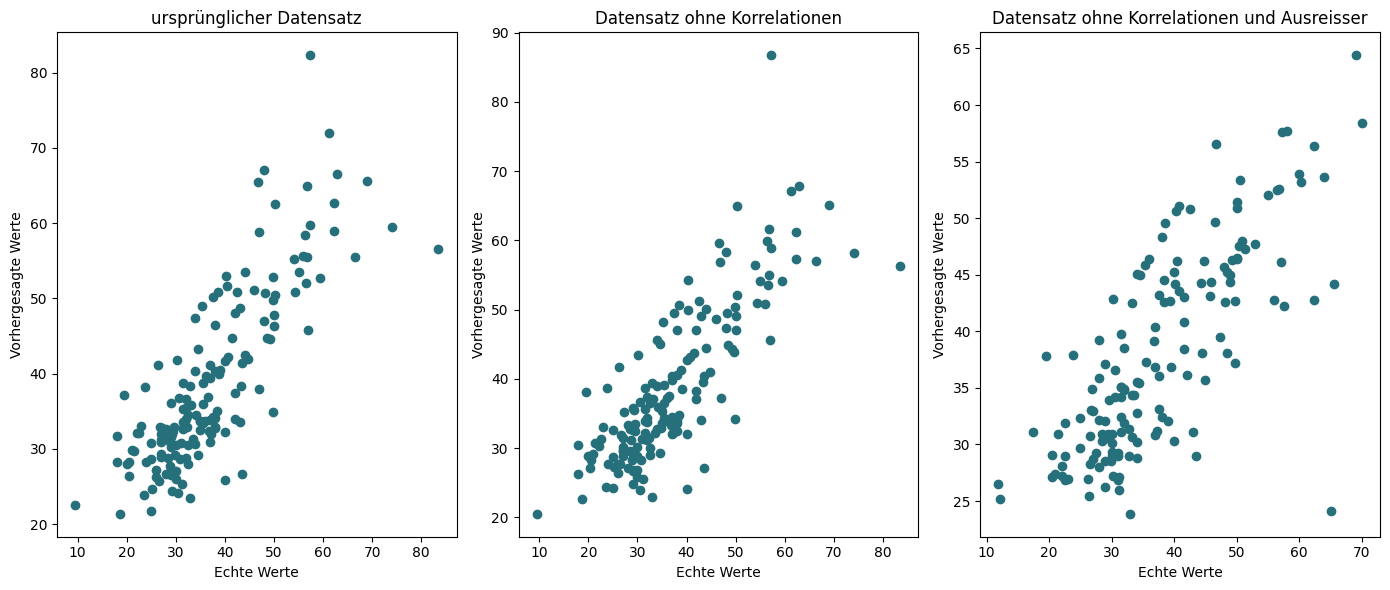

In [36]:
# Streudiagramme erstellen
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test_analysis, y_test_pred_analysis, c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('ursprünglicher Datensatz')

plt.subplot(1, 3, 2)
plt.scatter(y_test_cor, y_test_pred_cor,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen')

plt.subplot(1, 3, 3)
plt.scatter(y_test_outl, y_test_pred_outl,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen und Ausreisser')

plt.tight_layout()
plt.show()

# Hyperparameter-Tuning

In [39]:
# Hyperparameter-Tuning für Gradient Boosting
def tune_gb(X, y):
    param_grid = {
        'n_estimators': [100, 200, 300],        # -> Anzahl der Bäume im Modell
        'learning_rate': [0.01, 0.1, 0.05],     # -> Lernrate des Modells (kleinere Lernrate = höhere Anzahl von Bäumen)
        'max_depth': [3, 4, 5],                 # -> Maximale Tiefe der einzelnen Entscheidungsbäume
        'min_samples_split': [2, 5, 10],        # -> Minimale Anzahl von Samples, die erforderlich sind, um einen Split durchzuführen
        'min_samples_leaf': [1, 2, 4],          # -> Mindestanzahl von Samples, die ein Blattknoten haben muss.
        'subsample': [0.8, 0.9, 1.0]            # -> Der Anteil der Trainingsdaten, der für jeden einzelnen Baum verwendet wird
    }

    gb = GradientBoostingRegressor(random_state=42)
    gb_cv = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    gb_cv.fit(X, y)

    return gb_cv.best_estimator_,  gb_cv.best_params_

# Daten vorbereiten
X = df_analysis_outl.drop(columns=['Preis'])
y = df_analysis_outl['Preis']

# Hyperparameter-Tuning durchführen
best_gb_model, best_gb_params = tune_gb(X, y)

# Modell mit den besten Parametern trainieren und Metriken berechnen
metrics_gb, X_test_gb, y_test_gb, y_test_pred_gb, best_gb_model = gb_metrics(best_gb_model, df_analysis_outl)

# Ergebnisse anzeigen
print("Best parameters found: ", best_gb_params)
print(metrics_gb)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
{'train_r2': 0.859264461375372, 'test_r2': 0.5812772742497814, 'train_mse': 17.098176467898142, 'test_mse': 57.95953416671369, 'cross_val_r2_mean': 0.49819891466168603, 'cross_val_r2_std': 0.12663722670313757, 'cross_val_mse_mean': 60.98367035563501, 'cross_val_mse_std': 17.360621219639665}


# XAI

In [40]:
# Gradient Boosting Regressor - Modell mit Train-Test Split
def gb_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred, model.feature_importances_

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren
model = GradientBoostingRegressor(random_state=42,learning_rate=0.05, max_depth=4, min_samples_leaf=2, min_samples_split=5, n_estimators=100, subsample=0.8)

# Metriken für beide Datensätze berechnen
metrics_df_analysis_outl, X_test_outl, y_test_outl, y_test_pred_outl, feature_importances_outl = gb_metrics(model, df_analysis_outl)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis_outl], index=[ 'df_analysis_outl'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis_outl,0.859264,0.581277,17.098176,57.959534,0.498199,0.126637,60.98367,17.360621


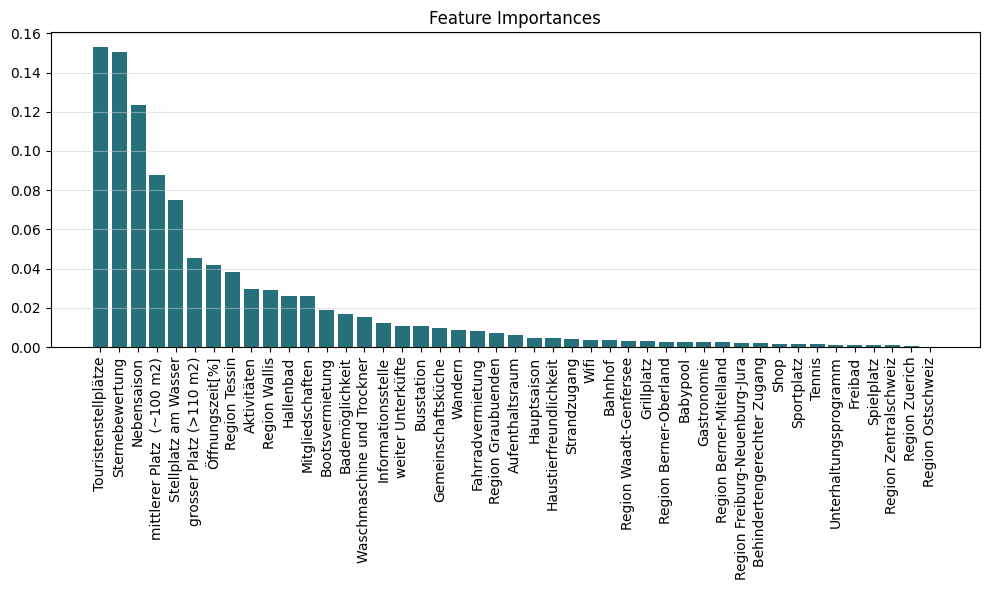

In [41]:
# Feature Importances anzeigen für den ursprünglichen Datensatz
features = df_analysis_outl.drop(columns=['Preis']).columns
sorted_indices_analysis = np.argsort(feature_importances_outl)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')

plt.bar(range(len(features)), feature_importances_outl[sorted_indices_analysis], align='center', color='#26707C')
plt.xticks(range(len(features)), [features[i] for i in sorted_indices_analysis], rotation=90)
plt.grid(axis='y', alpha=0.5, color='#CFCFCF')
plt.tight_layout()
plt.show()

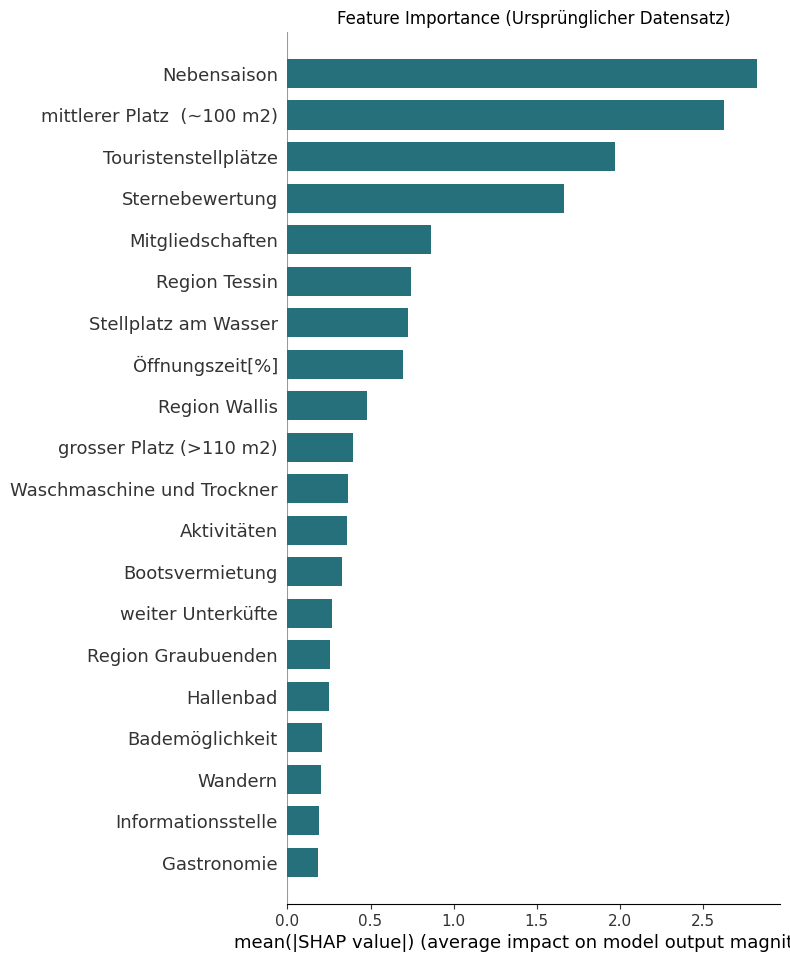

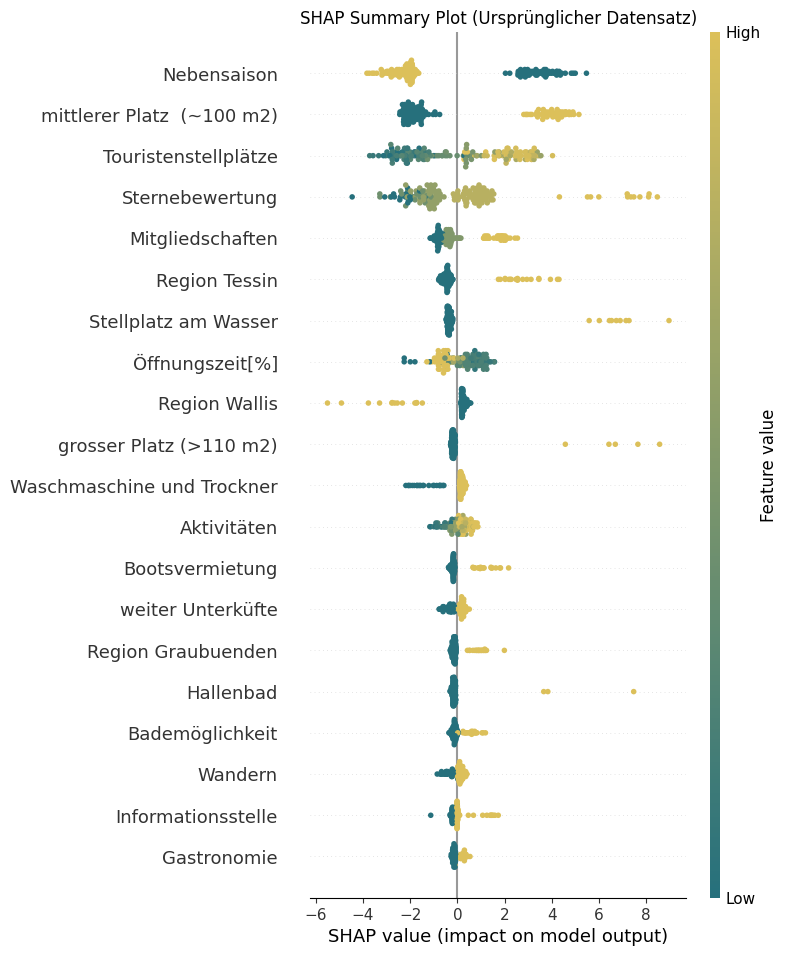

In [42]:
from matplotlib.colors import LinearSegmentedColormap

# SHAP-Analyse durchführen
explainer_analysis = shap.Explainer(model, X_test_outl)
shap_values_analysis = explainer_analysis(X_test_outl)

# SHAP-Werte visualisieren
shap.summary_plot(shap_values_analysis, X_test_outl, plot_type="bar", show=False, color='#26707C')
plt.title('Feature Importance (Ursprünglicher Datensatz)')
plt.show()

newCmap = LinearSegmentedColormap.from_list("", ['#26707C','#DCC05A'])
shap.summary_plot(shap_values_analysis, X_test_outl, show=False,cmap=newCmap)
plt.title('SHAP Summary Plot (Ursprünglicher Datensatz)')
plt.show()